In [1]:
import pandas as pandas
import numpy as np 
import jax.numpy as jnp
import jax.scipy.stats as jst
import jax
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
def random_process(S0, r, sigma, T, total_granularity, sim_size):
    increments = st.norm.rvs(0, 1, size = (sim_size, total_granularity))
    increments = increments * sigma / jnp.sqrt(total_granularity / T) + (r - sigma ** 2 / 2) / (total_granularity / T)

    paths = S0 * jnp.exp(jnp.cumsum(increments, axis = 1))
    return paths

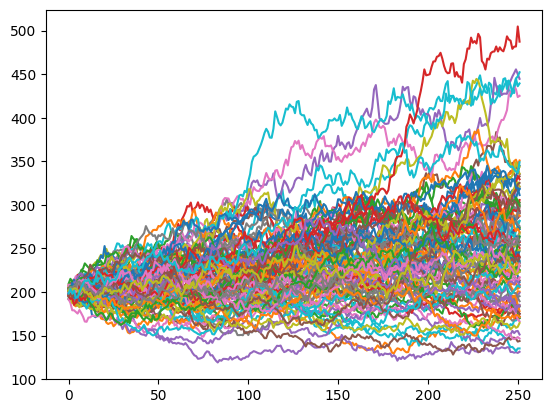

In [3]:
plt.plot(random_process(200, 0.1, 0.2, 2, 252, 100).T)
plt.show()

In [4]:
def european_call(S0, K, r, sigma, T, granularity = 252, sim_size = 100):
    paths = random_process(S0 = S0, r = r, sigma = sigma, T = T, total_granularity = granularity, sim_size = sim_size)
    PVs = jnp.fmax(paths[:, -1] - K, 0) / jnp.exp(r * T)
    return jnp.mean(PVs)

In [5]:
european_call(200., 230., 0.1, 0.2, 1, 252, 100000)

Array(12.678167, dtype=float32)

In [12]:
first_order_greeks = jax.grad(european_call, argnums = [0, 2, 3, 4])(200., 230., 0.1, 0.2, 1., 252, 100000)

print(f"Delta = {first_order_greeks[0]}")
print(f"DV01 = {first_order_greeks[1] * 0.0001}")
print(f"Vega = {first_order_greeks[2] / 100}")
print(f"Theta = {-first_order_greeks[3] / 252} per day")

Delta = 0.460575133562088
DV01 = 0.007960098795592785
Vega = 0.7935502529144287
Theta = -0.06307778507471085 per day


In [10]:
jax.value_and_grad(european_call, argnums = [0, 2, 3, 4])(200., 230., 0.1, 0.2, 1., 252, 100000)

(Array(12.583509, dtype=float32),
 (Array(0.4624625, dtype=float32, weak_type=True),
  Array(79.90901, dtype=float32, weak_type=True),
  Array(79.80243, dtype=float32, weak_type=True),
  Array(15.971146, dtype=float32, weak_type=True)))

In [234]:
def asian_call(S0, K, r, sigma, T, granularity = 252, sim_size = 100):
    paths = random_process(S0 = S0, r = r, sigma = sigma, T = T, total_granularity = granularity, sim_size = sim_size)
    PVs = jnp.fmax(jnp.mean(paths, axis = 1) - K, 0) / jnp.exp(r * T)
    return jnp.mean(PVs)

In [240]:
res = jax.value_and_grad(asian_call, argnums = [0, 2, 3, 4])(200., 230., 0.1, 0.2, 1., 252, 100000)
PV = res[0]
Delta = res[1][0]
DV01 = res[1][1] * 0.0001
Vega = res[1][2] * 0.01
Theta = -res[1][3] / 252
print(PV, Delta, DV01, Vega, Theta)

3.0597293 0.22875974 0.0021143523 0.35250312 -0.022378506
